https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [7]:
# Checking device availability

import torch
print("torch ready:", torch.cuda.is_available())
print("torch version:", torch.__version__)

torch ready: True
torch version: 2.1.0


In [8]:
# Auto assign cuda, mps and cpu by checking availability

def assign_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

device = assign_device()

print(f"Device: {device}")

Device: cuda:0


In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [10]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

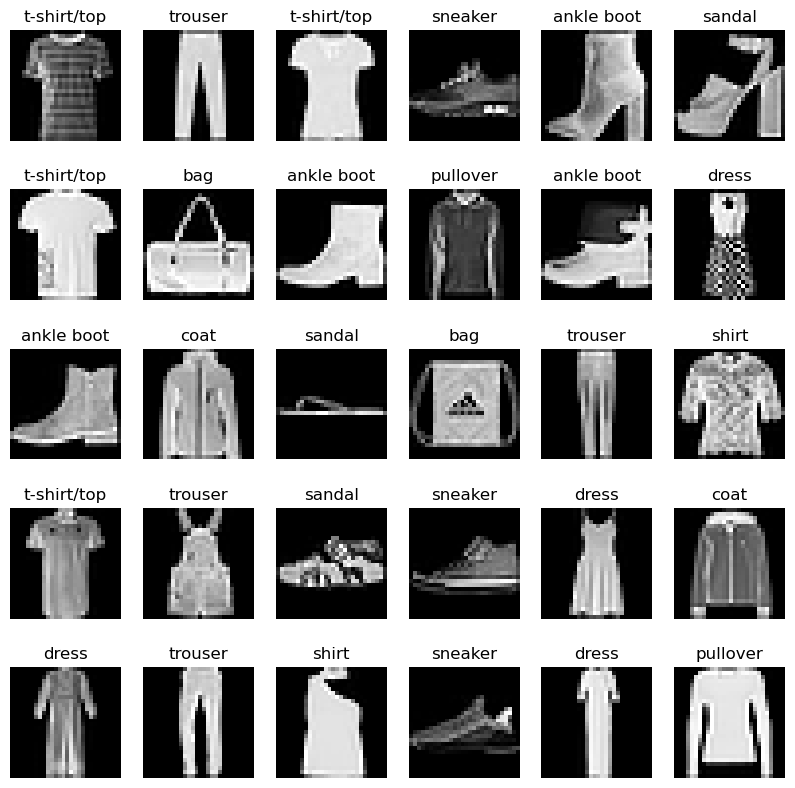

In [11]:
import matplotlib.pyplot as plt

train_data = training_data

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

In [12]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [13]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Assign device manually 
#device = "cpu"

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

print(f"Using {device} device")


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Using cuda device


In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
epochs = 5

print(f"Using device {device} for {epochs} epochs:\n")

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Using device cuda for 5 epochs:

Epoch 1
-------------------------------
loss: 2.304559  [   64/60000]
loss: 2.291902  [ 6464/60000]
loss: 2.273958  [12864/60000]
loss: 2.265255  [19264/60000]
loss: 2.248859  [25664/60000]
loss: 2.204679  [32064/60000]
loss: 2.216690  [38464/60000]
loss: 2.176717  [44864/60000]
loss: 2.181939  [51264/60000]
loss: 2.142314  [57664/60000]
Test Error: 
 Accuracy: 47.9%, Avg loss: 2.144153 

Epoch 2
-------------------------------
loss: 2.156554  [   64/60000]
loss: 2.144095  [ 6464/60000]
loss: 2.086628  [12864/60000]
loss: 2.104486  [19264/60000]
loss: 2.050740  [25664/60000]
loss: 1.975074  [32064/60000]
loss: 2.011011  [38464/60000]
loss: 1.925534  [44864/60000]
loss: 1.949588  [51264/60000]
loss: 1.858031  [57664/60000]
Test Error: 
 Accuracy: 52.5%, Avg loss: 1.865636 

Epoch 3
-------------------------------
loss: 1.906464  [   64/60000]
loss: 1.868148  [ 6464/60000]
loss: 1.754164  [12864/60000]
loss: 1.797524  [19264/60000]
loss: 1.692032  [25664/

In [18]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [19]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [33]:
import random

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
rnd = random.randint(0, len(test_data)-1)
x, y = test_data[rnd][0], test_data[rnd][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'No: {rnd}, Predicted: "{predicted}", Actual: "{actual}"')

No: 5497, Predicted: "Coat", Actual: "Shirt"
